In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
import glob

In [2]:
tf.__version__

'2.3.0'

In [3]:
gpus = tf.config.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(device=gpu, enable=True)

In [4]:
img = glob.glob('./dataset/leftImg8bit/train/*/*.png')  # tf.io.glob.glob

In [5]:
len(img)

2975

In [6]:
img[:5]

['./dataset/leftImg8bit/train\\aachen\\aachen_000000_000019_leftImg8bit.png',
 './dataset/leftImg8bit/train\\aachen\\aachen_000001_000019_leftImg8bit.png',
 './dataset/leftImg8bit/train\\aachen\\aachen_000002_000019_leftImg8bit.png',
 './dataset/leftImg8bit/train\\aachen\\aachen_000003_000019_leftImg8bit.png',
 './dataset/leftImg8bit/train\\aachen\\aachen_000004_000019_leftImg8bit.png']

In [7]:
label = glob.glob('./dataset/gtFine/train/*/*_gtFine_labelIds.png')

In [8]:
train_count = len(label)
train_count

2975

In [9]:
label[:3]

['./dataset/gtFine/train\\aachen\\aachen_000000_000019_gtFine_labelIds.png',
 './dataset/gtFine/train\\aachen\\aachen_000001_000019_gtFine_labelIds.png',
 './dataset/gtFine/train\\aachen\\aachen_000002_000019_gtFine_labelIds.png']

In [10]:
index = np.random.permutation(len(img))

In [11]:
img = np.array(img)[index]
label = np.array(label)[index]

In [12]:
img[:5]

array(['./dataset/leftImg8bit/train\\tubingen\\tubingen_000137_000019_leftImg8bit.png',
       './dataset/leftImg8bit/train\\strasbourg\\strasbourg_000001_020956_leftImg8bit.png',
       './dataset/leftImg8bit/train\\tubingen\\tubingen_000050_000019_leftImg8bit.png',
       './dataset/leftImg8bit/train\\dusseldorf\\dusseldorf_000175_000019_leftImg8bit.png',
       './dataset/leftImg8bit/train\\strasbourg\\strasbourg_000000_035571_leftImg8bit.png'],
      dtype='<U89')

In [13]:
label[:5]

array(['./dataset/gtFine/train\\tubingen\\tubingen_000137_000019_gtFine_labelIds.png',
       './dataset/gtFine/train\\strasbourg\\strasbourg_000001_020956_gtFine_labelIds.png',
       './dataset/gtFine/train\\tubingen\\tubingen_000050_000019_gtFine_labelIds.png',
       './dataset/gtFine/train\\dusseldorf\\dusseldorf_000175_000019_gtFine_labelIds.png',
       './dataset/gtFine/train\\strasbourg\\strasbourg_000000_035571_gtFine_labelIds.png'],
      dtype='<U88')

In [14]:
img_val = glob.glob('./dataset/leftImg8bit/val/*/*.png')
label_val = glob.glob('./dataset/gtFine/val/*/*_gtFine_labelIds.png')

In [15]:
val_count = len(img_val)
len(img_val), len(label_val)

(500, 500)

In [16]:
img_val[10:15]

['./dataset/leftImg8bit/val\\frankfurt\\frankfurt_000000_004617_leftImg8bit.png',
 './dataset/leftImg8bit/val\\frankfurt\\frankfurt_000000_005543_leftImg8bit.png',
 './dataset/leftImg8bit/val\\frankfurt\\frankfurt_000000_005898_leftImg8bit.png',
 './dataset/leftImg8bit/val\\frankfurt\\frankfurt_000000_006589_leftImg8bit.png',
 './dataset/leftImg8bit/val\\frankfurt\\frankfurt_000000_007365_leftImg8bit.png']

In [17]:
label_val[10:15]

['./dataset/gtFine/val\\frankfurt\\frankfurt_000000_004617_gtFine_labelIds.png',
 './dataset/gtFine/val\\frankfurt\\frankfurt_000000_005543_gtFine_labelIds.png',
 './dataset/gtFine/val\\frankfurt\\frankfurt_000000_005898_gtFine_labelIds.png',
 './dataset/gtFine/val\\frankfurt\\frankfurt_000000_006589_gtFine_labelIds.png',
 './dataset/gtFine/val\\frankfurt\\frankfurt_000000_007365_gtFine_labelIds.png']

In [18]:
dataset_train = tf.data.Dataset.from_tensor_slices((img, label))

In [19]:
dataset_train

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.string)>

In [20]:
dataset_val = tf.data.Dataset.from_tensor_slices((img_val, label_val))

In [21]:
def read_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img

In [22]:
def read_png_label(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    return img

In [23]:
img_1 = read_png(img[0])
label_1 = read_png_label(label[0])

In [24]:
img_1.shape

TensorShape([1024, 2048, 3])

In [25]:
label_1.shape

TensorShape([1024, 2048, 1])

# 数据增强

1.随机翻转   img = tf.image.flip_left_right()

2.随即裁剪

In [26]:
concat_img = tf.concat([img_1, label_1], axis=-1)

In [27]:
concat_img.shape

TensorShape([1024, 2048, 4])

In [28]:
def crop_img(img, mask):
    concat_img = tf.concat([img, mask], axis=-1)
    concat_img = tf.image.resize(concat_img, (280, 280),
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    crop_img = tf.image.random_crop(concat_img, [256, 256, 4])
    return crop_img[ :, :, :3], crop_img[ :, :, 3:]

In [29]:
img_1, label_1 = crop_img(img_1, label_1)

In [30]:
label_1.shape

TensorShape([256, 256, 1])

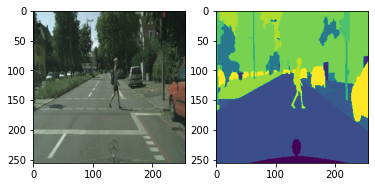

In [31]:
plt.subplot(1,2,1)
plt.imshow(img_1.numpy())
plt.subplot(1,2,2)
plt.imshow(np.squeeze(label_1.numpy()))

In [32]:
def normal(img, mask):
    img = tf.cast(img, tf.float32)/127.5 -1
    mask = tf.cast(mask, tf.int32)
    return img, mask

In [33]:
def load_image_train(img_path, mask_path):
    img = read_png(img_path)
    mask = read_png_label(mask_path)
    
    img, mask = crop_img(img, mask)
    
    if tf.random.uniform(())>0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
        
    img, mask = normal(img, mask)
    
    return img, mask

In [34]:
def load_image_val(img_path, mask_path):
    img = read_png(img_path)
    mask = read_png_label(mask_path)
    
    img = tf.image.resize(img, (256, 256))
    mask = tf.image.resize(mask, (256, 256))
        
    img, mask = normal(img, mask)
    
    return img, mask

In [35]:
BCTCH_SIZE = 6
BUFFER_SIZE = 300
step_per_epoch = train_count//BCTCH_SIZE
val_step = val_count//BCTCH_SIZE

In [36]:
auto = tf.data.experimental.AUTOTUNE

In [37]:
dataset_train = dataset_train.map(load_image_train, num_parallel_calls=auto)
dataset_val = dataset_val.map(load_image_val, num_parallel_calls=auto)

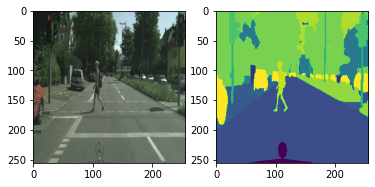

In [38]:
for i, m in dataset_train.take(1):
    plt.subplot(1,2,1)
    plt.imshow((i.numpy() + 1)/2)
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(m.numpy()))

In [39]:
dataset_train = dataset_train.shuffle(BUFFER_SIZE).batch(BCTCH_SIZE)
dataset_val = dataset_val.batch(BCTCH_SIZE)

# 定义unet模型

In [40]:
class Downsample(keras.layers.Layer):
    def __init__(self, units):
        super(Downsample, self).__init__()
        self.conv1 = keras.layers.Conv2D(units, kernel_size=3, padding='same')
        self.conv2 = keras.layers.Conv2D(units, kernel_size=3, padding='same')
        self.pool = keras.layers.MaxPooling2D()
    def call(self, x, is_pool=True):
        if is_pool:
            x = self.pool(x)
        x = self.conv1(x)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = tf.nn.relu(x)
        return x

In [41]:
class Upsample(keras.layers.Layer):
    def __init__(self, unit):
        super(Upsample, self).__init__()
        self.conv1 = keras.layers.Conv2D(unit, kernel_size=3, padding='same')
        self.conv2 = keras.layers.Conv2D(unit, kernel_size=3, padding='same')
        self.deconv = keras.layers.Conv2DTranspose(unit//2,
                                                   kernel_size=3,
                                                   strides=2,
                                                   padding='same')
        
    def call(self, x, is_pool=True):
        x = self.conv1(x)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = tf.nn.relu(x)
        x = self.deconv(x)
        x = tf.nn.relu(x)
        return x

In [42]:
class Net(keras.Model):
    def __init__(self):
        super(Net, self).__init__()
        self.down1 = Downsample(64)
        self.down2 = Downsample(128)
        self.down3 = Downsample(256)
        self.down4 = Downsample(512)
        self.down5 = Downsample(1024)
        
        self.up1 = Upsample(512)
        self.up2 = Upsample(256)
        self.up3 = Upsample(128)
        
        self.conv_last = Downsample(64)
        
        self.up = keras.layers.Conv2DTranspose(512,
                                               kernel_size=3,
                                               strides = 2,
                                               padding='same')
        
        self.last = keras.layers.Conv2D(34,
                                        kernel_size=1,
                                        padding='same')

    def call(self, x):
        x1 = self.down1(x, is_pool=False)         # 256*256*64
        x2 = self.down2(x1)                       # 128*128*128
        x3 = self.down3(x2)                       # 64*64*256
        x4 = self.down4(x3)                       # 32*32*512
        x5 = self.down5(x4)                       # 16*16*1024
        
        x5 = self.up(x5)                          # 32*32*512
        
        x5 = tf.concat([x4,x5], axis=-1)          # 32*32*1024
        x5 = self.up1(x5)                         # 64*64*256
        x5 = tf.concat([x3,x5], axis=-1)          # 64*64*512   
        x5 = self.up2(x5)                         # 128*128*128
        x5 = tf.concat([x2,x5], axis=-1)          # 128*128*256
        x5 = self.up3(x5)                         # 256*256*64
        x5 = tf.concat([x1,x5], axis=-1)          # 256*256*128
        
        x5 = self.conv_last(x5, is_pool=False)    # 256*256*64
        
        x5 = self.last(x5)                        # 256*256*3
        return x5

In [43]:
model = Net()

In [44]:
#tf.keras.utils.plot_model(model)                     # conda install pydot

In [45]:
class MeanIoU(tf.keras.metrics.MeanIoU):
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().__call__(y_true, y_pred, sample_weight=sample_weight)

In [46]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [47]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [48]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
train_iou = MeanIoU(34, name='train_iou')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
test_iou = MeanIoU(34, name='test_iou')

In [49]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    train_iou(labels, predictions)

In [50]:
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)
    test_iou(labels, predictions)

In [51]:


EPOCHS = 60

for epoch in range(EPOCHS):
    # 在下一个epoch开始时，重置评估指标
    train_loss.reset_states()
    train_accuracy.reset_states()
    train_iou.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    test_iou.reset_states()

    for images, labels in dataset_train:
        train_step(images, labels)

    for test_images, test_labels in dataset_val:
        test_step(test_images, test_labels)

    template = 'Epoch {:.3f}, Loss: {:.3f}, Accuracy: {:.3f}, \
                IOU: {:.3f}, Test Loss: {:.3f}, \
                Test Accuracy: {:.3f}, Test IOU: {:.3f}'
    print (template.format(epoch+1,
                           train_loss.result(),
                           train_accuracy.result()*100,
                           train_iou.result(),
                           test_loss.result(),
                           test_accuracy.result()*100,
                           test_iou.result() 
                           ))

Epoch 1.000, Loss: 1.659, Accuracy: 51.076,                 IOU: 0.058, Test Loss: 1.319,                 Test Accuracy: 59.580, Test IOU: 0.078
Epoch 2.000, Loss: 1.119, Accuracy: 65.038,                 IOU: 0.094, Test Loss: 1.260,                 Test Accuracy: 62.844, Test IOU: 0.082
Epoch 3.000, Loss: 0.934, Accuracy: 73.421,                 IOU: 0.124, Test Loss: 1.118,                 Test Accuracy: 70.207, Test IOU: 0.114
Epoch 4.000, Loss: 0.825, Accuracy: 77.399,                 IOU: 0.143, Test Loss: 0.992,                 Test Accuracy: 74.606, Test IOU: 0.137
Epoch 5.000, Loss: 0.764, Accuracy: 79.206,                 IOU: 0.155, Test Loss: 0.888,                 Test Accuracy: 76.744, Test IOU: 0.149
Epoch 6.000, Loss: 0.724, Accuracy: 80.347,                 IOU: 0.165, Test Loss: 0.876,                 Test Accuracy: 77.285, Test IOU: 0.151
Epoch 7.000, Loss: 0.679, Accuracy: 81.594,                 IOU: 0.176, Test Loss: 0.823,                 Test Accuracy: 79.067, T

Epoch 58.000, Loss: 0.203, Accuracy: 93.583,                 IOU: 0.624, Test Loss: 0.757,                 Test Accuracy: 85.022, Test IOU: 0.314
Epoch 59.000, Loss: 0.200, Accuracy: 93.680,                 IOU: 0.624, Test Loss: 0.817,                 Test Accuracy: 84.902, Test IOU: 0.317
Epoch 60.000, Loss: 0.204, Accuracy: 93.568,                 IOU: 0.614, Test Loss: 0.812,                 Test Accuracy: 85.029, Test IOU: 0.317
